In [161]:
import json
import simpledorff
from collections import defaultdict, Counter
from pprint import pprint
import numpy as np
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau

DATA_FILE = '../data/data_with_overlap_scores.json'
SUBMISSION_FILE = '../data/submission_info.json'

data = []
with open(DATA_FILE, 'r') as f:
    for line in f:
        data.append(json.loads(line))
        
with open(SUBMISSION_FILE, 'r') as f:
    submissions = json.load(f)


## Load data

In [162]:
cochrane = [d for d in data if d['subtask'] == 'Cochrane']
ms2 = [d for d in data if d['subtask'] == 'MS2']

cochrane_annot = [d for d in cochrane if any(entry['annotations'] for entry in d['predictions'])]
ms2_annot = [d for d in ms2 if any(entry['annotations'] for entry in d['predictions'])]

cochrane_metrics = [d for d in cochrane if any(entry['scores'] for entry in d['predictions'])]
ms2_metrics = [d for d in ms2 if any(entry['scores'] for entry in d['predictions'])]

print('Cochrane: ', len(cochrane))
print('w/ annotations: ', len(cochrane_annot))
print('w/ metrics: ', len(cochrane_metrics))
print()

print('MS2: ', len(ms2))
print('w/ annotations: ', len(ms2_annot))
print('w/ metrics: ', len(ms2_metrics))

Cochrane:  274
w/ annotations:  274
w/ metrics:  274

MS2:  0
w/ annotations:  0
w/ metrics:  0


## Aggregate scores

In [163]:
data_to_analyze = []
for entry in cochrane:
    for pred in entry['predictions']:
        data_entry = {
            'review_id': entry['review_id'],
            'exp_id': pred['exp_short'],
            'exp_name': submissions[pred['exp_short']]['name']
        }
        annot_dict = dict()
        annot_dict['annotated'] = False
        if pred['annotations']:
            annot = pred['annotations'][0]
            if not annot['population']:
                annot['population'] = 0
            if not annot['intervention']:
                annot['intervention'] = 0
            if not annot['outcome']:
                annot['outcome'] = 0
            if not annot['ed_target']:
                annot['ed_target'] = -1
            if not annot['ed_generated']:
                annot['ed_generated'] = -1
            if not annot['strength_target']:
                annot['strength_target'] = 0
            if not annot['strength_generated']:
                annot['strength_generated'] = 0
            annot_dict = {
                'annot_id': annot['annot_id'],
                'fluency_normalized': annot['fluency'] / 2.0,
                'pio_normalized': (annot['population'] + annot['intervention'] + annot['outcome']) / 6.0,
                'ed_normalized': (2.0 - abs(abs(annot.get('ed_target')) - abs(annot.get('ed_generated')))) / 2.0,
                'strength_normalized': (3.0 - (abs(annot.get('strength_target')) - abs(annot.get('strength_generated')))) / 3.0
            }
            annot_dict['annot_all'] = np.mean([
                annot_dict['fluency_normalized'], 
                annot_dict['pio_normalized'], 
                annot_dict['ed_normalized'], 
                annot_dict['strength_normalized']
            ])
            annot_dict['annotated'] = True
        score_dict = dict()
        score_dict['scored'] = False
        if pred['scores']:
            score_dict = {
                'rouge_avg_f': np.mean([
                    pred['scores']['rouge1_f'],
                    pred['scores']['rouge2_f'],
                    pred['scores']['rougeL_f']
                ]),
                'rougeLsum_f': pred['scores']['rougeLsum_f'],
                'bertscore_f': pred['scores']['bertscore_f'] if pred['scores']['bertscore_f'] > 0.5 else None,
                'ei_score': pred['scores']['ei_score'],
                'claimver': pred['scores']['claimver'],
                'sts': pred['scores']['sts'],
                'nli': pred['scores']['nli']            
            }
            score_dict['scored'] = True
        overlap_scores_dict = dict()
        overlap_scores_dict['overlap_scored'] = False
        if pred['overlap_scores']:
            overlap_scores_dict = {
                'p_overlap_exact_match': pred['overlap_scores']['exact_match']['PAR'],
                'i_overlap_exact_match': pred['overlap_scores']['exact_match']['INT'],
                'o_overlap_exact_match': pred['overlap_scores']['exact_match']['OUT'],

                'p_overlap_close_match': pred['overlap_scores']['close_match']['PAR'],
                'i_overlap_close_match': pred['overlap_scores']['close_match']['INT'],
                'o_overlap_close_match': pred['overlap_scores']['close_match']['OUT'],

                'p_overlap_substring': pred['overlap_scores']['substring']['PAR'],
                'i_overlap_substring': pred['overlap_scores']['substring']['INT'],
                'o_overlap_substring': pred['overlap_scores']['substring']['OUT'],

                'pio_overlap_substring': np.mean([
                    pred['overlap_scores']['substring']['PAR'],
                    pred['overlap_scores']['substring']['INT'],
                    pred['overlap_scores']['substring']['OUT'],
                ]),
                'pio_overlap_exact_match': np.mean([
                    pred['overlap_scores']['exact_match']['PAR'],
                    pred['overlap_scores']['exact_match']['INT'],
                    pred['overlap_scores']['exact_match']['OUT'],
                ]),
                'pio_overlap_close_match': np.mean([
                    pred['overlap_scores']['close_match']['PAR'],
                    pred['overlap_scores']['close_match']['INT'],
                    pred['overlap_scores']['close_match']['OUT'],
                ]),
            }
            overlap_scores_dict['overlap_scored'] = True
        data_entry.update(annot_dict)
        data_entry.update(score_dict)
        data_entry.update(overlap_scores_dict)
        data_to_analyze.append(data_entry)

In [164]:
print('Number entries: ', len(data_to_analyze))
print('Number annotated: ', len([entry for entry in data_to_analyze if entry['annotated']]))
print('Number scored: ', len([entry for entry in data_to_analyze if entry['scored']]))

Number entries:  2714
Number annotated:  597
Number scored:  2712


In [165]:
EXP_W_ANNOTS = set([entry['exp_id'] for entry in data_to_analyze if entry['annotated']])
pprint([submissions[exp]['name'] for exp in EXP_W_ANNOTS])

['led-base-16384-cochrane',
 'ittc2',
 'bart-large-finetuned',
 'ittc1',
 'AI2/BART/train Cochrane/decode Cochrane',
 'SciSpace']


In [166]:
data_to_analyze = [entry for entry in data_to_analyze if entry['exp_id'] in EXP_W_ANNOTS]
df = pd.DataFrame.from_records(data_to_analyze)
display(df)

,review_id,exp_id,exp_name,annot_id,fluency_normalized,pio_normalized,ed_normalized,strength_normalized,annot_all,annotated,...,p_overlap_close_match,i_overlap_close_match,o_overlap_close_match,p_overlap_substring,i_overlap_substring,o_overlap_substring,pio_overlap_substring,pio_overlap_exact_match,pio_overlap_close_match,overlap_scored
0,CD000220,SPNXTA,led-base-16384-cochrane,0.0,0.5,0.833333,1.0,1.000000,0.833333,True,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
1,CD000220,8FWF5T,SciSpace,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
2,CD000220,JB6Z8F,ittc2,0.0,1.0,1.000000,0.5,0.333333,0.708333,True,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
3,CD000220,AQ85CE,bart-large-finetuned,0.0,1.0,0.833333,1.0,1.000000,0.958333,True,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.000000,0.333333,True
4,CD000220,VNCH8M,ittc1,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,CD003412,8FWF5T,SciSpace,1.0,0.5,0.500000,0.5,0.666667,0.541667,True,...,0.0,0.5,0.0,0.0,0.5,0.0,0.166667,0.000000,0.166667,True
1636,CD003412,JB6Z8F,ittc2,1.0,1.0,0.166667,0.5,0.666667,0.583333,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
1637,CD003412,AQ85CE,bart-large-finetuned,1.0,1.0,0.333333,1.0,1.000000,0.833333,True,...,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,True
1638,CD003412,VNCH8M,ittc1,1.0,0.0,0.333333,0.5,0.666667,0.375000,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True


## Entries with annotations

In [167]:
df_annot = df[df['annotated'] == True]
display(df_annot)

,review_id,exp_id,exp_name,annot_id,fluency_normalized,pio_normalized,ed_normalized,strength_normalized,annot_all,annotated,...,p_overlap_close_match,i_overlap_close_match,o_overlap_close_match,p_overlap_substring,i_overlap_substring,o_overlap_substring,pio_overlap_substring,pio_overlap_exact_match,pio_overlap_close_match,overlap_scored
0,CD000220,SPNXTA,led-base-16384-cochrane,0.0,0.5,0.833333,1.0,1.000000,0.833333,True,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
1,CD000220,8FWF5T,SciSpace,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
2,CD000220,JB6Z8F,ittc2,0.0,1.0,1.000000,0.5,0.333333,0.708333,True,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
3,CD000220,AQ85CE,bart-large-finetuned,0.0,1.0,0.833333,1.0,1.000000,0.958333,True,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.000000,0.333333,True
4,CD000220,VNCH8M,ittc1,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,CD003412,8FWF5T,SciSpace,1.0,0.5,0.500000,0.5,0.666667,0.541667,True,...,0.0,0.5,0.0,0.0,0.5,0.0,0.166667,0.000000,0.166667,True
1636,CD003412,JB6Z8F,ittc2,1.0,1.0,0.166667,0.5,0.666667,0.583333,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
1637,CD003412,AQ85CE,bart-large-finetuned,1.0,1.0,0.333333,1.0,1.000000,0.833333,True,...,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,True
1638,CD003412,VNCH8M,ittc1,1.0,0.0,0.333333,0.5,0.666667,0.375000,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True


In [168]:
Counter(df_annot['exp_id'])

Counter({'SPNXTA': 100,
         '8FWF5T': 99,
         'JB6Z8F': 100,
         'AQ85CE': 98,
         'VNCH8M': 100,
         'PX7SGV': 100})

In [169]:
counts_per = defaultdict(int)
for rev_id, count in Counter(df_annot['review_id']).items():
    counts_per[count] += 1
    
pprint(counts_per)

defaultdict(<class 'int'>, {6: 50, 1: 162, 2: 52, 3: 9, 4: 1})


## Pairwise relationship between PIO overlap and human-annotated metrics 

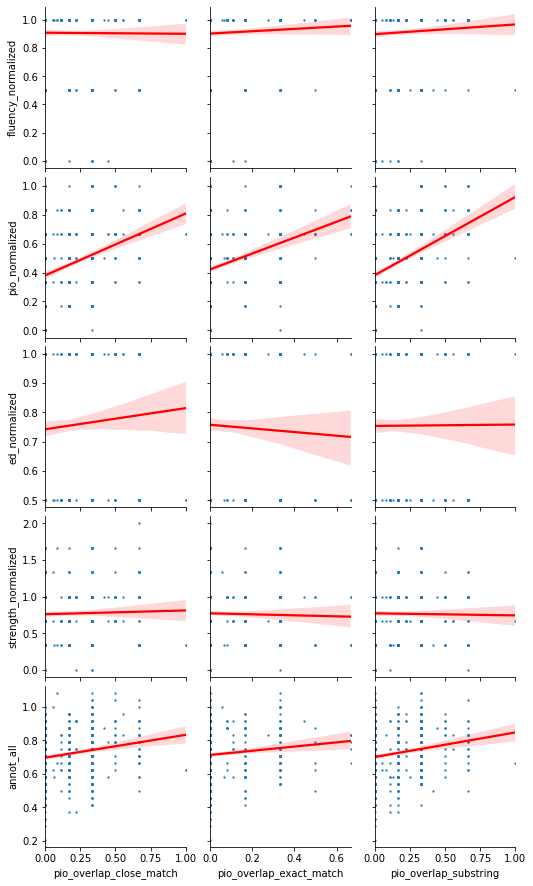

In [170]:
sns.pairplot(
    df_annot, 
#     hue="exp_name",
    diag_kind="kde",
    x_vars=["pio_overlap_close_match", "pio_overlap_exact_match", "pio_overlap_substring" ],
    y_vars=[
        "fluency_normalized", "pio_normalized", "ed_normalized", "strength_normalized", "annot_all"
#         "pio_normalized"
    ],
#     kind="scatter",
#     palette="muted",
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 2}
    }
)
plt.show()

In [171]:
score_keys = [
    'rouge_avg_f',
    'ei_score',
    'claimver',
    'nli',
    'sts'
]

overlap_score_keys = [
    'pio_overlap_exact_match',
    'pio_overlap_close_match',
    'pio_overlap_substring',
]


annot_keys = [
    'annot_all',
    'fluency_normalized',
    'pio_normalized',
    'ed_normalized',
    'strength_normalized'
]

corr_vals = []
for score_k, annot_k in itertools.product(overlap_score_keys, annot_keys):
    p_r, p_p = pearsonr(df_annot[score_k], df_annot[annot_k])
    s_r, s_p = spearmanr(df_annot[score_k], df_annot[annot_k])
    k_t, k_p = kendalltau(df_annot[score_k], df_annot[annot_k])
    corr_vals.append({
        'score': score_k,
        'annot': annot_k,
        'p_r': p_r,
        'p_p': p_p,
        's_r': s_r,
        's_p': s_p,
        'k_t': k_t,
        'k_p': k_p
    })
for score_k, annot_k in itertools.product(score_keys, annot_keys):
    p_r, p_p = pearsonr(df_annot[score_k], df_annot[annot_k])
    s_r, s_p = spearmanr(df_annot[score_k], df_annot[annot_k])
    k_t, k_p = kendalltau(df_annot[score_k], df_annot[annot_k])
    corr_vals.append({
        'score': score_k,
        'annot': annot_k,
        'p_r': p_r,
        'p_p': p_p,
        's_r': s_r,
        's_p': s_p,
        'k_t': k_t,
        'k_p': k_p
    })


## Correlation with human-annotated PIO

In [172]:
[entry for entry in corr_vals if entry['annot'] == 'pio_normalized']

[{'score': 'pio_overlap_exact_match',
  'annot': 'pio_normalized',
  'p_r': 0.285239985616099,
  'p_p': 1.2215527620820526e-12,
  's_r': 0.2712807244104575,
  's_p': 1.5698988384711908e-11,
  'k_t': 0.2351424256167303,
  'k_p': 2.2698361947613367e-11},
 {'score': 'pio_overlap_close_match',
  'annot': 'pio_normalized',
  'p_r': 0.34532398061053415,
  'p_p': 3.6721250327975585e-18,
  's_r': 0.3422256783323914,
  's_p': 7.600578700444875e-18,
  'k_t': 0.2856599684869222,
  'k_p': 2.4520219515973227e-17},
 {'score': 'pio_overlap_substring',
  'annot': 'pio_normalized',
  'p_r': 0.4026963355425073,
  'p_p': 1.110698170604399e-24,
  's_r': 0.3938139005497595,
  's_p': 1.385267659596194e-23,
  'k_t': 0.33223116960812793,
  'k_p': 1.559330199626375e-22},
 {'score': 'rouge_avg_f',
  'annot': 'pio_normalized',
  'p_r': -0.010119213205738919,
  'p_p': 0.805111949005259,
  's_r': -0.009603496745706952,
  's_p': 0.8148596346861176,
  'k_t': -0.006946276203626052,
  'k_p': 0.8153508313529576},
 {'sc

## Systems ranking

In [173]:
annot_order = df_annot.groupby(by=["exp_id"])["annot_all"].mean().sort_values(ascending=False)
pio_order = df_annot.groupby(by=["exp_id"])["pio_normalized"].mean().sort_values(ascending=False)
rouge_order = df_annot.groupby(by=["exp_id"])["rouge_avg_f"].mean().sort_values(ascending=False)
eid_order = df_annot.groupby(by=["exp_id"])["ei_score"].mean().sort_values(ascending=True)

overlap_exact_match_order = df_annot.groupby(by=["exp_id"])["pio_overlap_exact_match"].mean().sort_values(ascending=False)
overlap_close_match_order = df_annot.groupby(by=["exp_id"])["pio_overlap_close_match"].mean().sort_values(ascending=False)
overlap_substring_order = df_annot.groupby(by=["exp_id"])["pio_overlap_substring"].mean().sort_values(ascending=False)

# for a, p, r, e in zip(annot_order, pio_order, rouge_order, eid_order):
#     print(a, p, r, e)
print(annot_order)
print(pio_order)
print(rouge_order)
print(eid_order)
print(overlap_exact_match_order)
print(overlap_close_match_order)
print(overlap_substring_order)


exp_id
SPNXTA    0.797917
VNCH8M    0.776250
AQ85CE    0.749150
PX7SGV    0.693333
JB6Z8F    0.687917
8FWF5T    0.616582
Name: annot_all, dtype: float64
exp_id
VNCH8M    0.516667
SPNXTA    0.483333
PX7SGV    0.440000
JB6Z8F    0.433333
AQ85CE    0.423469
8FWF5T    0.412458
Name: pio_normalized, dtype: float64
exp_id
JB6Z8F    0.167245
8FWF5T    0.159802
AQ85CE    0.152054
SPNXTA    0.146111
VNCH8M    0.144164
PX7SGV    0.126785
Name: rouge_avg_f, dtype: float64
exp_id
JB6Z8F    0.207814
AQ85CE    0.244611
8FWF5T    0.251985
VNCH8M    0.283077
SPNXTA    0.320848
PX7SGV    0.427931
Name: ei_score, dtype: float64
exp_id
VNCH8M    0.079167
JB6Z8F    0.058611
SPNXTA    0.054167
PX7SGV    0.052889
8FWF5T    0.047419
AQ85CE    0.040816
Name: pio_overlap_exact_match, dtype: float64
exp_id
VNCH8M    0.191111
SPNXTA    0.188056
PX7SGV    0.178167
JB6Z8F    0.160278
8FWF5T    0.140853
AQ85CE    0.140590
Name: pio_overlap_close_match, dtype: float64
exp_id
VNCH8M    0.161111
PX7SGV    0.143556
AQ8

## Correlation between PIO overlap and overall human ranking

In [174]:
human = ['VNCH8M', 'JB6Z8F', 'AQ85CE', 'SPNXTA', 'PX7SGV', '8FWF5T']
s_r, s_p = spearmanr(human, list(overlap_exact_match_order.index))
print('pio_overlap_exact_match', s_r)
s_r, s_p = spearmanr(human, list(overlap_close_match_order.index))
print('pio_overlap_close_match', s_r)
s_r, s_p = spearmanr(human, list(overlap_substring_order.index))
print('pio_overlap_substring', s_r)
s_r, s_p = spearmanr(human, list(rouge_order.index))
print('rouge_avg_f', s_r)

pio_overlap_exact_match 0.4285714285714286
pio_overlap_close_match 0.3714285714285715
pio_overlap_substring 0.8285714285714287
rouge_avg_f 0.2571428571428572


## Correlation between PIO overlap and human-annotated PIO

In [175]:
s_r, s_p = spearmanr(pio_order, list(overlap_exact_match_order.index))
print('pio_overlap_exact_match', s_r)
s_r, s_p = spearmanr(pio_order, list(overlap_close_match_order.index))
print('pio_overlap_close_match', s_r)
s_r, s_p = spearmanr(pio_order, list(overlap_substring_order.index))
print('pio_overlap_substring', s_r)
s_r, s_p = spearmanr(pio_order, list(rouge_order.index))
print('rouge_avg_f', s_r)

pio_overlap_exact_match 0.7714285714285715
pio_overlap_close_match 0.942857142857143
pio_overlap_substring 0.6
rouge_avg_f -0.6571428571428573
